In [0]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-j985gpq7
  Stored in directory: /tmp/pip-ephem-wheel-cache-tio2xxbg/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS


In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership


## GEFCOM'12 preprocessed data

In [0]:

import pandas as pd
dataset = pd.read_csv('https://query.data.world/s/w477v3qx2zqea5mzv3wg3wcqu2fzwj')

In [0]:
dataset = dataset.dropna()
dataset.head()

train_uv = dataset['load'].values[:25000]
test_uv = dataset['load'].values[25000:]

train_mv = dataset.iloc[:25000]
test_mv = dataset.iloc[25000:]

del(dataset)

## Variables and partitioning

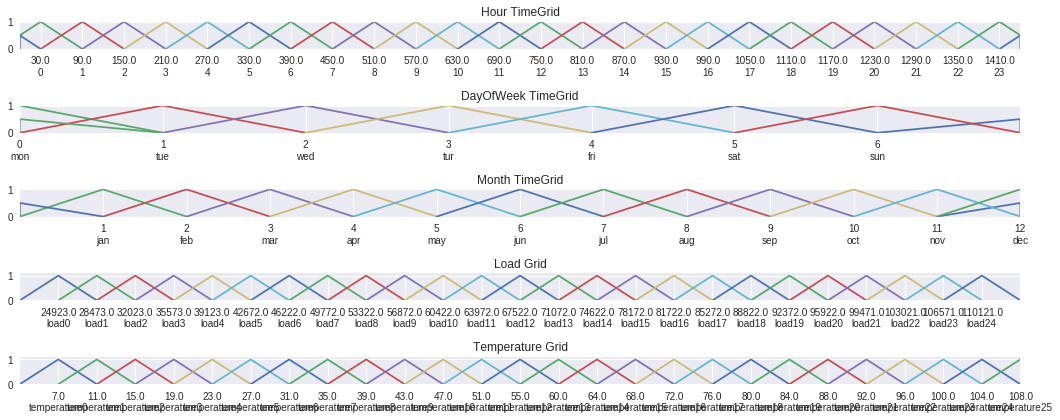

In [0]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Entropy

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=[15,6])

sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k) for k in range(0,24)]}
#sp = {'seasonality': DateTime.hour, 'names': [str(k) for k in range(0,24)]}

vhour = variable.Variable("Hour", data_label="date", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train_mv, partitioner_specific=sp)

vhour.partitioner.plot(ax[0])

sp = {'seasonality': DateTime.day_of_week, 'names': ['mon','tue','wed','tur','fri','sat','sun']}

vday = variable.Variable("DayOfWeek", data_label="date", partitioner=seasonal.TimeGridPartitioner, npart=7, 
                          data=train_mv, partitioner_specific=sp)

vday.partitioner.plot(ax[1])

#sp = {'seasonality': DateTime.day_of_year, 'names': ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']}
sp = {'seasonality': DateTime.month, 'names': ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']}

vmonth = variable.Variable("Month", data_label="date", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                          data=train_mv, partitioner_specific=sp)

vmonth.partitioner.plot(ax[2])


vload = variable.Variable("Load", data_label="load", alias='load',
                         partitioner=Grid.GridPartitioner, npart=25, 
                         data=train_mv) 

vload.partitioner.plot(ax[3])

vtemp = variable.Variable("Temperature", data_label="temperature", alias='temperature',
                         partitioner=Grid.GridPartitioner, npart=25, 
                         data=train_mv) 

vtemp.partitioner.plot(ax[4])

plt.tight_layout()

## Temperature Forecaster - Context Sensitive

In [0]:
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid

mtemp = wmvfts.WeightedMVFTS(explanatory_variables=[vhour, vmonth, vtemp], target_variable=vtemp)
mtemp.fit(train_mv)

### One step ahead model performance

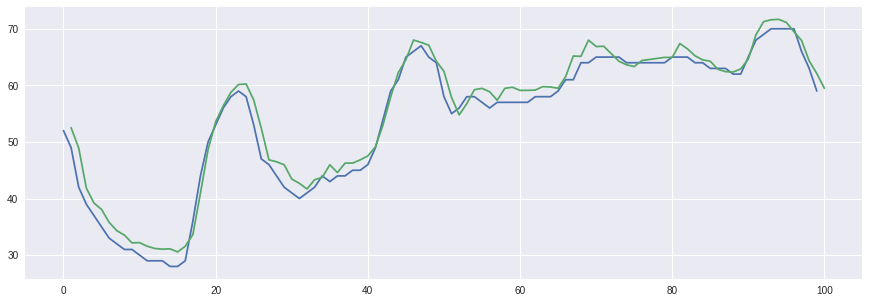

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_mv['temperature'].values[:100],label='Original')

forecasts = mtemp.predict(test_mv.iloc[:100])

forecasts.insert(0,None)

ax.plot(forecasts,label='forecasts')


## Temperature Forecaster - Context Insensitive

(Average temperature by month and hour)

In [0]:
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid

mtemp2 = wmvfts.WeightedMVFTS(explanatory_variables=[vhour, vmonth], target_variable=vtemp)
mtemp2.fit(train_mv)

### One step ahead model performance

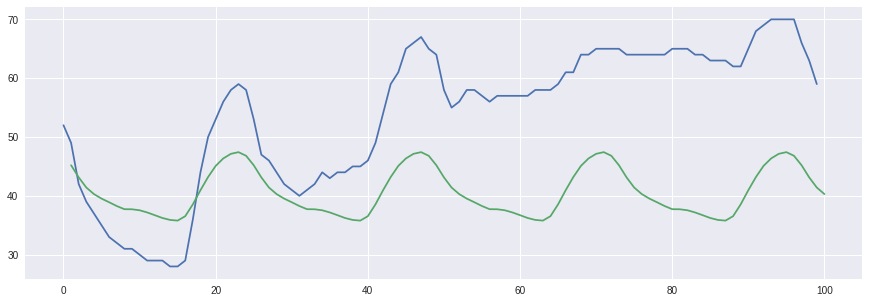

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_mv['temperature'].values[:100],label='Original')

forecasts = mtemp2.predict(test_mv.iloc[:100])

forecasts.insert(0,None)

ax.plot(forecasts,label='forecasts')


## Load Forecaster

In [0]:
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid

mload = wmvfts.WeightedMVFTS(explanatory_variables=[vtemp, vload], target_variable=vload)
mload.fit(train_mv)

### One step ahead model performance

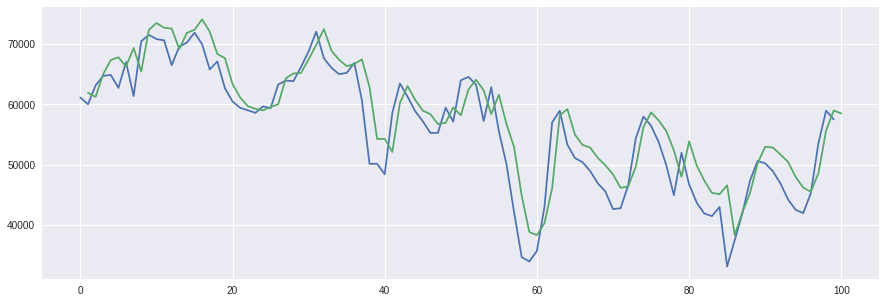

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_mv['load'].values[:100],label='Original')

forecasts = mload.predict(test_mv.iloc[:100])

forecasts.insert(0,None)

ax.plot(forecasts,label='forecasts')


## Forecast Ahead with Naïve temperature generator

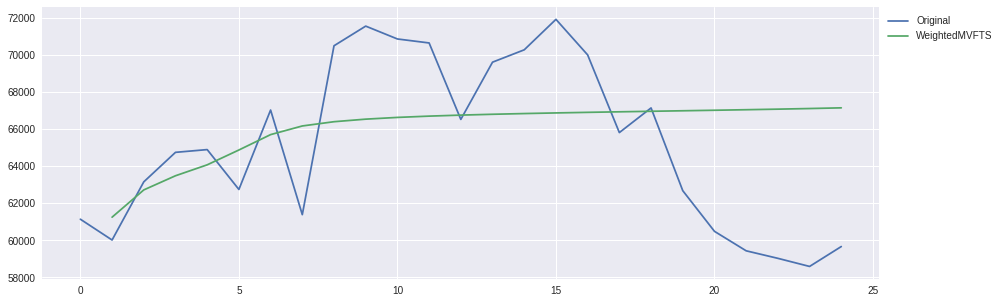

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_mv['load'].iloc[:25].values,label='Original')


time_generator = lambda x : pd.to_datetime(x) + pd.to_timedelta(1, unit='h')
temp_generator = lambda x : x

forecasts = mload.predict(test_mv.iloc[:2], steps_ahead=24, 
                          generators={'date': time_generator,
                                      'temperature': temp_generator})
for k in np.arange(mload.order):
  forecasts.insert(0,None)

ax.plot(forecasts, label=mload.shortname)
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

## Forecast Ahead with MVFTS temperature model generator (context sensitive)

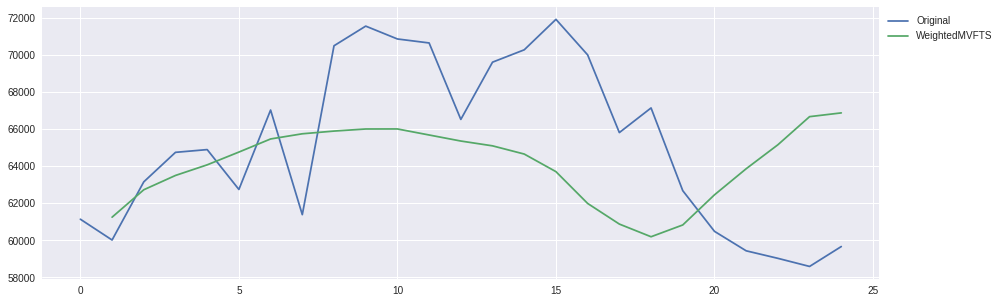

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_mv['load'].iloc[:25].values,label='Original')

time_generator = lambda x : pd.to_datetime(x) + pd.to_timedelta(1, unit='h')

forecasts = mload.predict(test_mv.iloc[:2], steps_ahead=24, 
                          generators={'date': time_generator,
                                      'temperature': mtemp})
for k in np.arange(mload.order):
  forecasts.insert(0,None)

ax.plot(forecasts, label=mload.shortname)
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

## Forecast Ahead with MVFTS temperature model generator (context insensitive)

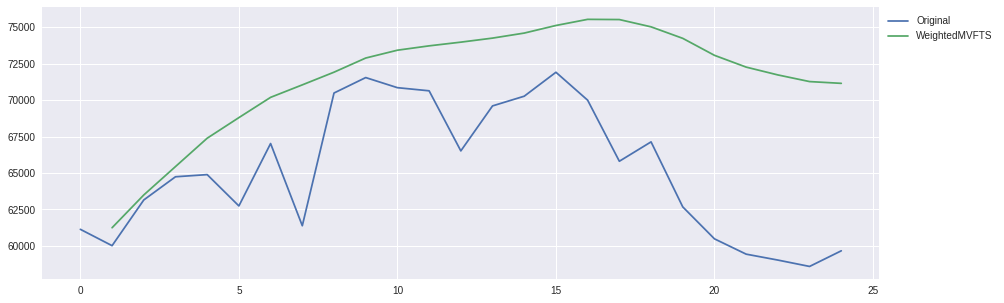

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_mv['load'].iloc[:25].values,label='Original')

time_generator = lambda x : pd.to_datetime(x) + pd.to_timedelta(1, unit='h')

forecasts = mload.predict(test_mv.iloc[:2], steps_ahead=24, 
                          generators={'date': time_generator,
                                      'temperature': mtemp2})
for k in np.arange(mload.order):
  forecasts.insert(0,None)

ax.plot(forecasts, label=mload.shortname)
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))